In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 2
commitnumber = 47e1a90
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 257
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

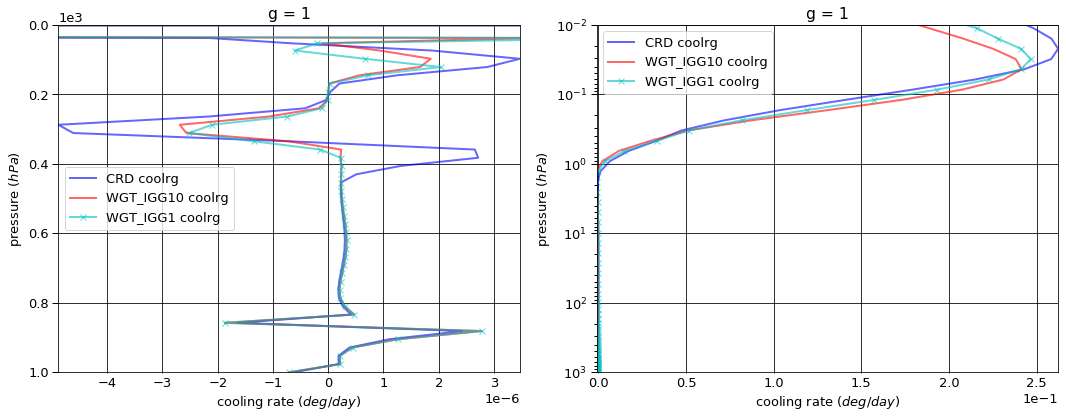

# Figure: cooling rate g-group 2

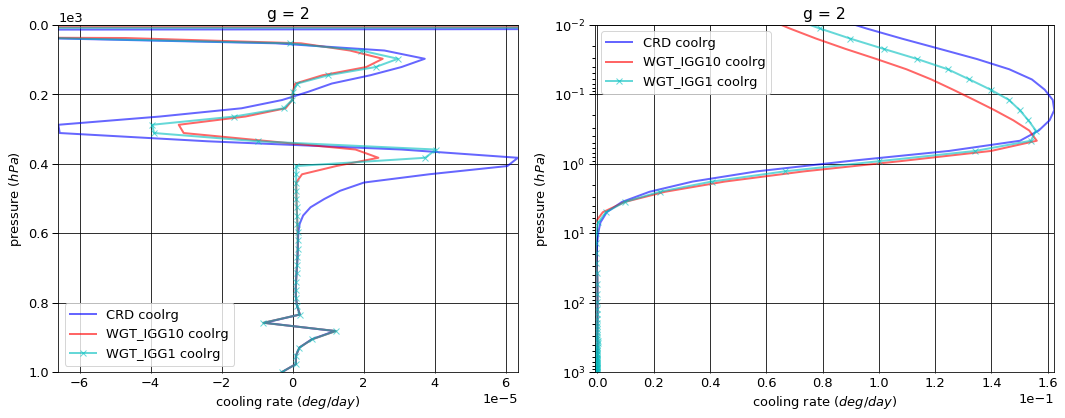

# Figure: cooling rate g-group 3

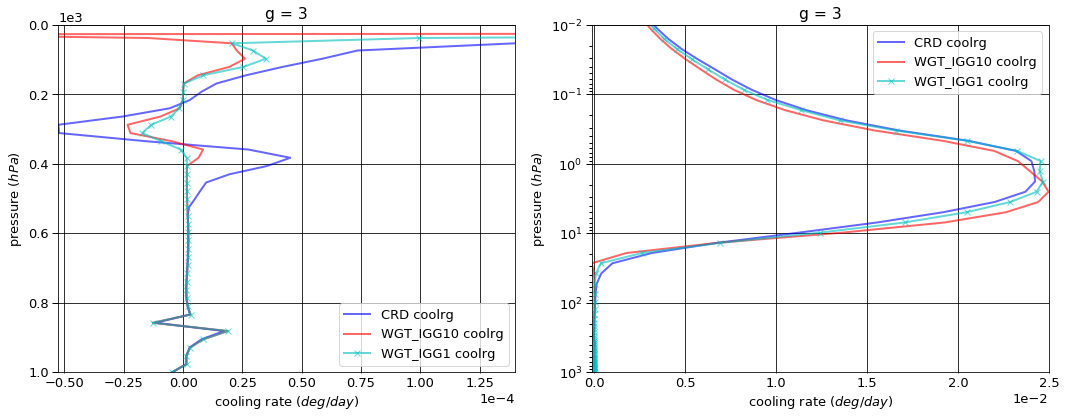

# Figure: cooling rate g-group 4

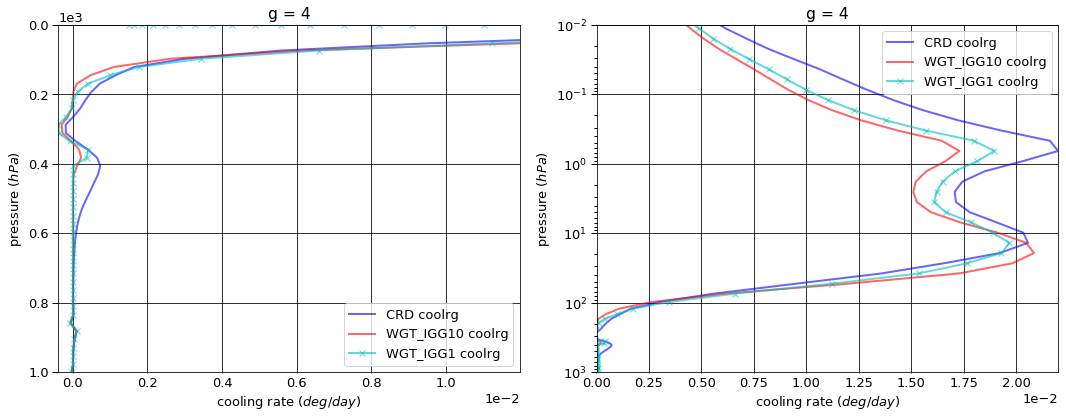

# Figure: cooling rate g-group 5

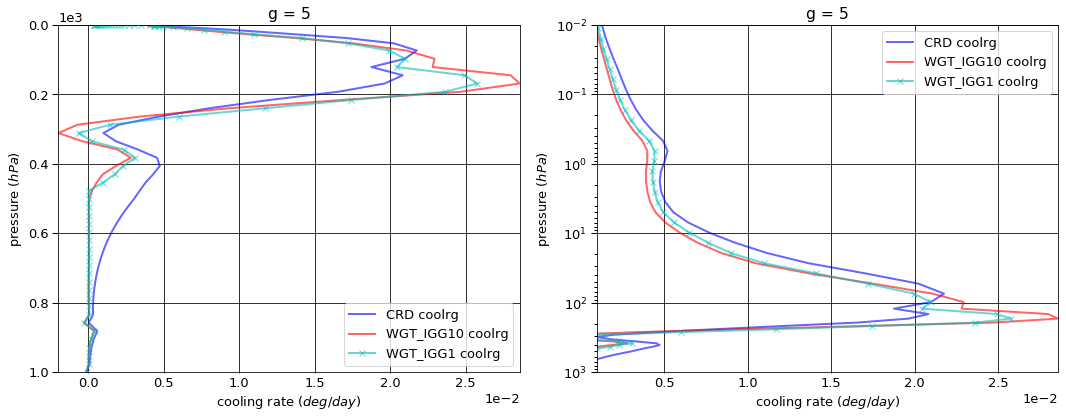

# Figure: cooling rate g-group 6

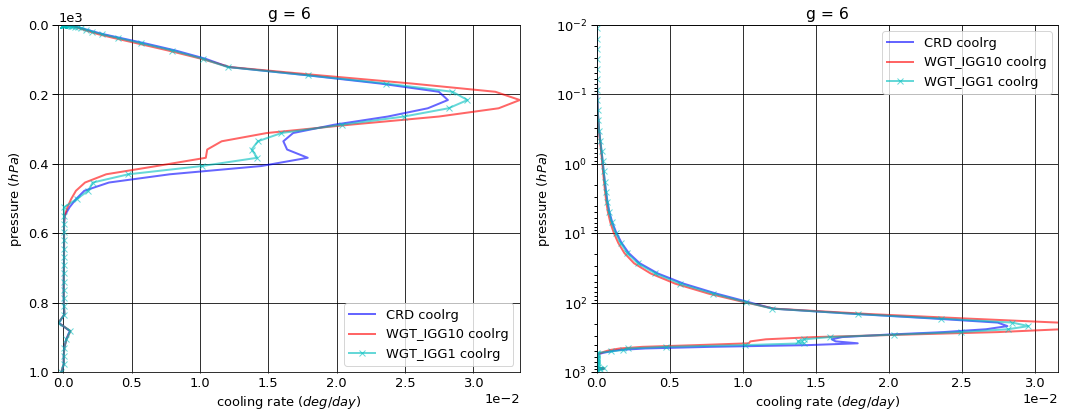

# Figure: cooling rate g-group 7

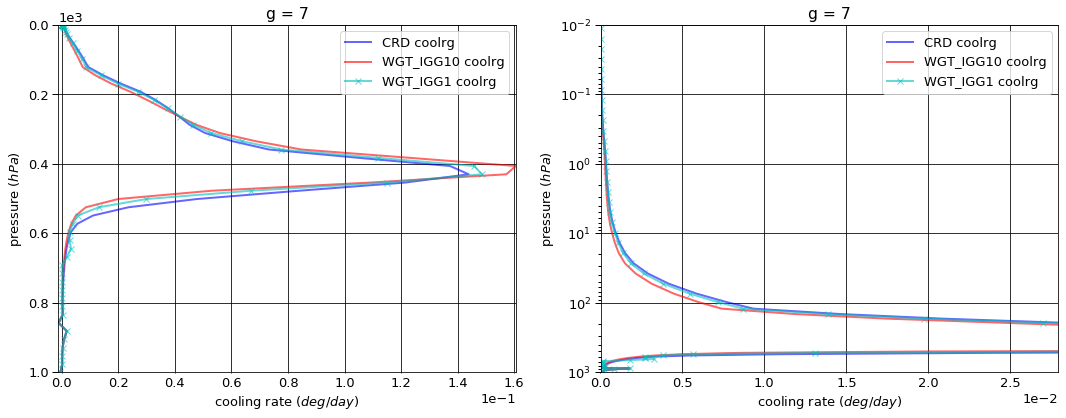

# Figure: cooling rate g-group 8

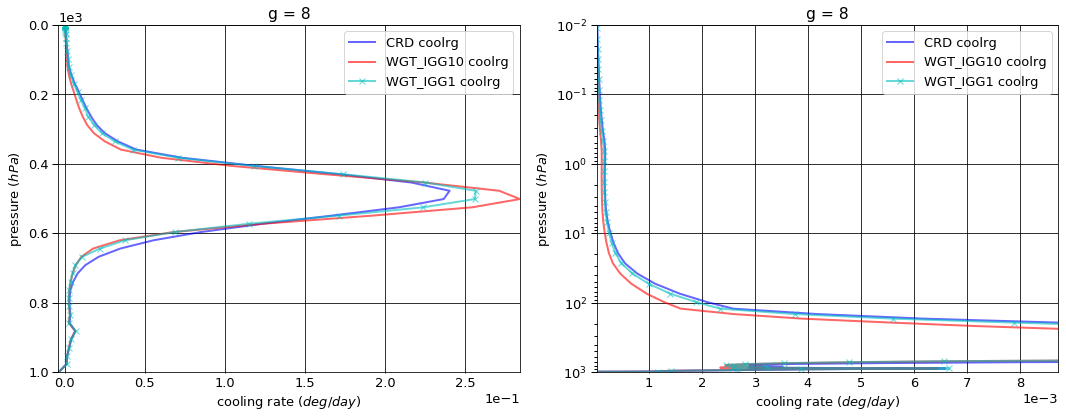

# Figure: cooling rate g-group 9

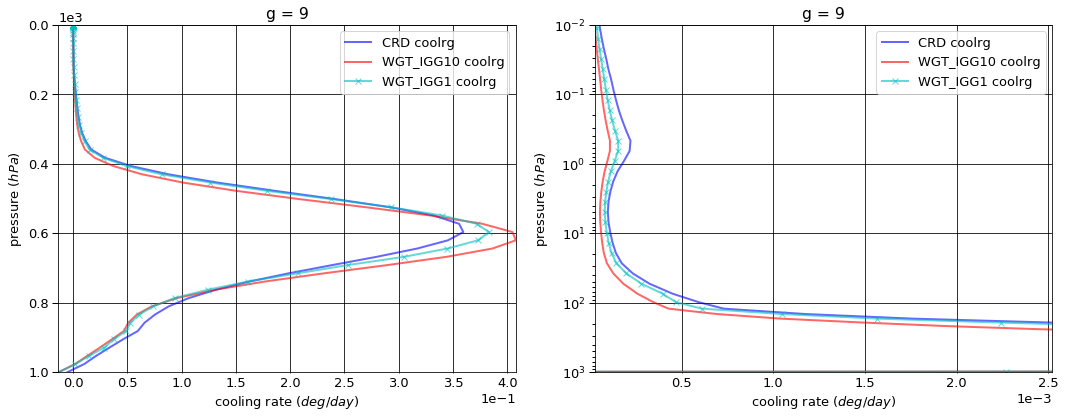

# Figure: cooling rate g-group 10

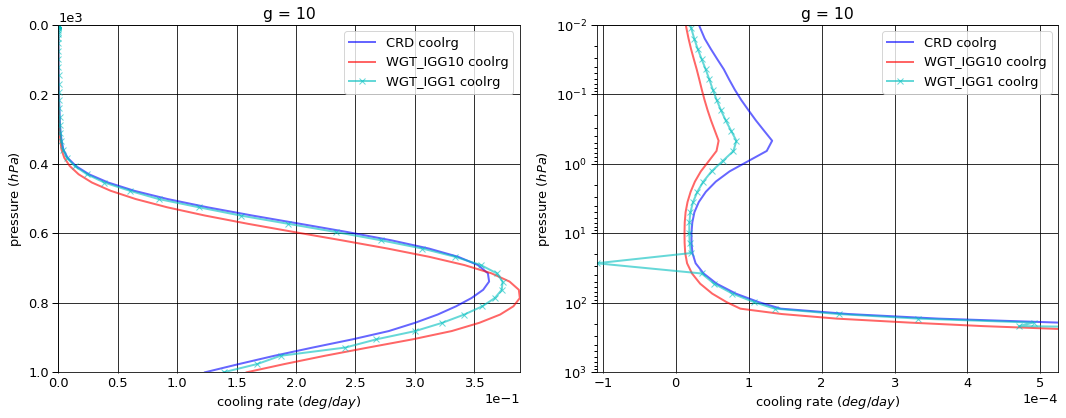

# Figure: cooling rate g-group 11

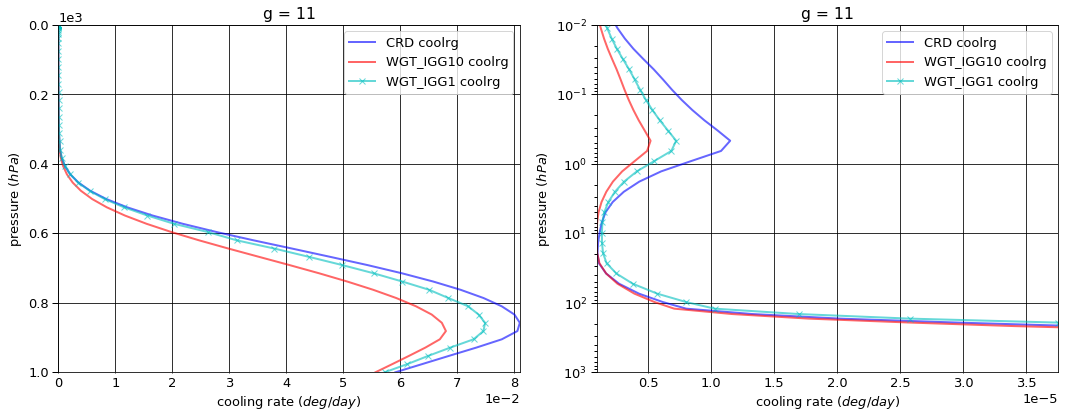

# Figure: cooling rate g-group total

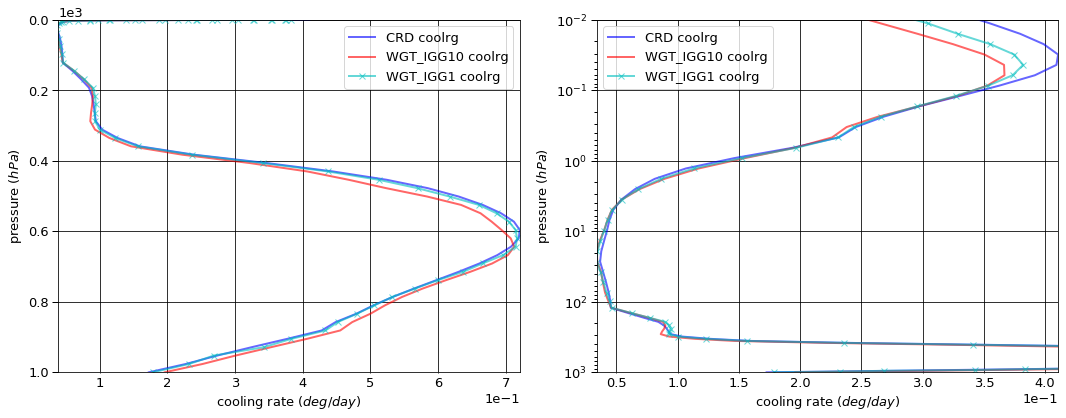

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006305   0.000000  -0.006305
   1013.0   76     -0.006844   0.006846   0.000002
2  0.0      1      -0.025646   0.000000  -0.025646
   1013.0   76     -0.030242   0.030252   0.000011
3  0.0      1      -0.032098   0.000000  -0.032098
   1013.0   76     -0.046806   0.046821   0.000015
4  0.0      1      -0.159569   0.000000  -0.159569
   1013.0   76     -0.252603   0.252726   0.000123
5  0.0      1      -0.642126   0.000000  -0.642126
   1013.0   76     -0.986034   0.986276   0.000242
6  0.0      1      -0.854648   0.000000  -0.854648
   1013.0   76     -1.309782   1.310204   0.000423
7  0.0      1      -3.173013   0.000000  -3.173013
   1013.0   76     -4.473250   4.474934   0.001684
8  0.0      1      -5.612975   0.000000  -5.612975
   1013.0   76     -7.087958   7.103363   0.015405
9  0.0      1     -12.099283   0.000000 -12.099283
   1013.0   76    -13.700012  13.739998   0.039986
10 0.0      1     -20.235601   0.000000 -20.235601
   1013.0   76    -21.118582  17.386504  -3.732079
11 0.0      1      -9.073466   0.000000  -9.073466
   1013.0   76     -9.171416   3.508865  -5.662551


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006322   0.000000  -0.006322
   1013.0   76     -0.006904   0.006906   0.000002
2  0.0      1      -0.026256   0.000000  -0.026256
   1013.0   76     -0.030310   0.030321   0.000011
3  0.0      1      -0.031434   0.000000  -0.031434
   1013.0   76     -0.047107   0.047123   0.000017
4  0.0      1      -0.151715   0.000000  -0.151715
   1013.0   76     -0.253901   0.253990   0.000089
5  0.0      1      -0.602866   0.000000  -0.602866
   1013.0   76     -0.990975   0.991324   0.000349
6  0.0      1      -0.815088   0.000000  -0.815088
   1013.0   76     -1.318058   1.318522   0.000464
7  0.0      1      -3.071162   0.000000  -3.071162
   1013.0   76     -4.496177   4.497932   0.001755
8  0.0      1      -5.577112   0.000000  -5.577112
   1013.0   76     -7.118687   7.132949   0.014262
9  0.0      1     -12.150725   0.000000 -12.150725
   1013.0   76    -13.730419  13.845204   0.114784
10 0.0      1     -20.408072   0.000000 -20.408072
   1013.0   76    -21.096789  17.626530  -3.470259
11 0.0      1      -9.034922   0.000000  -9.034922
   1013.0   76     -9.094203   2.829203  -6.265000


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006312   0.000000  -0.006312
   1013.0   76     -0.006904   0.006906   0.000002
2  0.0      1      -0.026044   0.000000  -0.026044
   1013.0   76     -0.030310   0.030321   0.000011
3  0.0      1      -0.031319   0.000000  -0.031319
   1013.0   76     -0.047107   0.047123   0.000017
4  0.0      1      -0.152288   0.000000  -0.152288
   1013.0   76     -0.253901   0.253990   0.000089
5  0.0      1      -0.603356   0.000000  -0.603356
   1013.0   76     -0.990975   0.991324   0.000349
6  0.0      1      -0.819996   0.000000  -0.819996
   1013.0   76     -1.318058   1.318522   0.000464
7  0.0      1      -3.080056   0.000000  -3.080056
   1013.0   76     -4.496177   4.497760   0.001583
8  0.0      1      -5.525543   0.000000  -5.525543
   1013.0   76     -7.118687   7.133587   0.014900
9  0.0      1     -12.046341   0.000000 -12.046341
   1013.0   76    -13.730419  13.838394   0.107975
10 0.0      1     -20.258299   0.000000 -20.258299
   1013.0   76    -21.096789  17.785266  -3.311523
11 0.0      1      -9.012978   0.000000  -9.012978
   1013.0   76     -9.094203   3.258528  -5.835674


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1     -0.000017  0.000000 -1.736360e-05
   1013.0   76    -0.000060  0.000060  2.996352e-07
2  0.0      1     -0.000609  0.000000 -6.094360e-04
   1013.0   76    -0.000068  0.000068  3.662200e-08
3  0.0      1      0.000664  0.000000  6.641570e-04
   1013.0   76    -0.000301  0.000302  1.498393e-06
4  0.0      1      0.007854  0.000000  7.853730e-03
   1013.0   76    -0.001297  0.001264 -3.340996e-05
5  0.0      1      0.039259  0.000000  3.925949e-02
   1013.0   76    -0.004941  0.005048  1.067669e-04
6  0.0      1      0.039560  0.000000  3.955994e-02
   1013.0   76    -0.008276  0.008318  4.124311e-05
7  0.0      1      0.101851  0.000000  1.018511e-01
   1013.0   76    -0.022927  0.022998  7.099140e-05
8  0.0      1      0.035862  0.000000  3.586220e-02
   1013.0   76    -0.030729  0.029586 -1.143057e-03
9  0.0      1     -0.051442  0.000000 -5.144200e-02
   1013.0   76    -0.030407  0.105206  7.479797e-02
10 0.0      1     -0.172471  0.000000 -1.724710e-01
   1013.0   76     0.021793  0.240026  2.618199e-01
11 0.0      1      0.038544  0.000000  3.854370e-02
   1013.0   76     0.077214 -0.679663 -6.024489e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1     -0.000007  0.000000 -6.916300e-06
   1013.0   76    -0.000060  0.000060  2.996352e-07
2  0.0      1     -0.000398  0.000000 -3.979620e-04
   1013.0   76    -0.000068  0.000068  3.662200e-08
3  0.0      1      0.000779  0.000000  7.791350e-04
   1013.0   76    -0.000301  0.000302  1.498393e-06
4  0.0      1      0.007281  0.000000  7.280560e-03
   1013.0   76    -0.001297  0.001264 -3.340996e-05
5  0.0      1      0.038770  0.000000  3.877003e-02
   1013.0   76    -0.004941  0.005048  1.067669e-04
6  0.0      1      0.034652  0.000000  3.465214e-02
   1013.0   76    -0.008276  0.008318  4.124311e-05
7  0.0      1      0.092957  0.000000  9.295690e-02
   1013.0   76    -0.022927  0.022826 -1.010369e-04
8  0.0      1      0.087432  0.000000  8.743210e-02
   1013.0   76    -0.030729  0.030224 -5.046070e-04
9  0.0      1      0.052942  0.000000  5.294200e-02
   1013.0   76    -0.030407  0.098396  6.798863e-02
10 0.0      1     -0.022698  0.000000 -2.269800e-02
   1013.0   76     0.021793  0.398762  4.205558e-01
11 0.0      1      0.060487  0.000000  6.048730e-02
   1013.0   76     0.077214 -0.250337 -1.731232e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.003190e-01
   1001.112500 75    -6.193751e-07
2  0.000312    1      2.354995e-02
   1001.112500 75    -3.085855e-06
3  0.000312    1      7.327994e-04
   1001.112500 75    -4.385430e-06
4  0.000312    1      1.797079e-03
   1001.112500 75    -3.289494e-05
5  0.000312    1      3.903814e-04
   1001.112500 75    -1.302332e-04
6  0.000312    1      2.071115e-06
   1001.112500 75    -1.229043e-04
7  0.000312    1      7.033949e-06
   1001.112500 75    -4.818975e-04
8  0.000312    1      8.501639e-06
   1001.112500 75    -3.853794e-03
9  0.000312    1      1.135368e-05
   1001.112500 75    -5.420770e-03
10 0.000312    1      5.139105e-06
   1001.112500 75     1.234679e-01
11 0.000312    1      1.726532e-07
   1001.112500 75     5.913915e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      4.765711e-02
   1001.112500 75    -7.068309e-07
2  0.000312    1      1.709547e-02
   1001.112500 75    -3.103123e-06
3  0.000312    1      7.303420e-04
   1001.112500 75    -4.822790e-06
4  0.000312    1      1.403936e-03
   1001.112500 75    -2.599435e-05
5  0.000312    1      3.327612e-04
   1001.112500 75    -1.014561e-04
6  0.000312    1      1.769386e-06
   1001.112500 75    -1.349428e-04
7  0.000312    1      5.281960e-06
   1001.112500 75    -5.007163e-04
8  0.000312    1      4.165868e-06
   1001.112500 75    -3.933914e-03
9  0.000312    1      4.960087e-06
   1001.112500 75    -1.349422e-02
10 0.000312    1      2.154791e-06
   1001.112500 75     1.585583e-01
11 0.000312    1      1.568265e-07
   1001.112500 75     5.564583e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      6.423789e-02
   1001.112500 75    -7.068309e-07
2  0.000312    1      1.817948e-02
   1001.112500 75    -3.103123e-06
3  0.000312    1      7.461951e-04
   1001.112500 75    -4.822790e-06
4  0.000312    1      1.511249e-03
   1001.112500 75    -2.599435e-05
5  0.000312    1      3.696749e-04
   1001.112500 75    -1.014561e-04
6  0.000312    1      1.963159e-06
   1001.112500 75    -1.349428e-04
7  0.000312    1      6.563067e-06
   1001.112500 75    -4.603188e-04
8  0.000312    1      6.284802e-06
   1001.112500 75    -4.084862e-03
9  0.000312    1      7.878092e-06
   1001.112500 75    -1.295290e-02
10 0.000312    1      3.537794e-06
   1001.112500 75     1.390829e-01
11 0.000312    1      2.374012e-07
   1001.112500 75     5.725085e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.266191e-02
   1001.112500 75    -8.745581e-08
2  0.000312    1     -6.454487e-03
   1001.112500 75    -1.726730e-08
3  0.000312    1     -2.457460e-06
   1001.112500 75    -4.373601e-07
4  0.000312    1     -3.931429e-04
   1001.112500 75     6.900590e-06
5  0.000312    1     -5.762016e-05
   1001.112500 75     2.877713e-05
6  0.000312    1     -3.017289e-07
   1001.112500 75    -1.203852e-05
7  0.000312    1     -1.751989e-06
   1001.112500 75    -1.881881e-05
8  0.000312    1     -4.335771e-06
   1001.112500 75    -8.012010e-05
9  0.000312    1     -6.393596e-06
   1001.112500 75    -8.073447e-03
10 0.000312    1     -2.984314e-06
   1001.112500 75     3.509039e-02
11 0.000312    1     -1.582674e-08
   1001.112500 75    -3.493316e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.608113e-02
   1001.112500 75    -8.745581e-08
2  0.000312    1     -5.370476e-03
   1001.112500 75    -1.726730e-08
3  0.000312    1      1.339561e-05
   1001.112500 75    -4.373601e-07
4  0.000312    1     -2.858304e-04
   1001.112500 75     6.900590e-06
5  0.000312    1     -2.070654e-05
   1001.112500 75     2.877713e-05
6  0.000312    1     -1.079563e-07
   1001.112500 75    -1.203852e-05
7  0.000312    1     -4.708817e-07
   1001.112500 75     2.157864e-05
8  0.000312    1     -2.216837e-06
   1001.112500 75    -2.310682e-04
9  0.000312    1     -3.475591e-06
   1001.112500 75    -7.532125e-03
10 0.000312    1     -1.601311e-06
   1001.112500 75     1.561499e-02
11 0.000312    1      6.474796e-08
   1001.112500 75    -1.888299e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.914729,0.000000,-51.914729
1013.0,76,-58.183530,48.846791,-9.336739



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.875674,0.000000,-51.875674
1013.0,76,-58.183529,48.580004,-9.603526



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.562532,0.000000,-51.562532
1013.0,76,-58.183529,49.161722,-9.021807



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.905452e-02,0.000000,0.039055
1013.0,76,3.646000e-07,-0.266787,-0.266787



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.521973e-01,0.000000,0.352197
1013.0,76,3.646000e-07,0.314931,0.314932


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.126824
1001.112500,75,0.172556



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.067238
1001.112500,75,0.196004



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.085071
1001.112500,75,0.178565



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.059585
1001.112500,75,0.023448



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.041753
1001.112500,75,0.006008


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
